In [1]:
import began
import healpy as hp
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import h5py
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord, Galactic
from astropy import units as u
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)

## Inputs

Input directory is specified, and map path.

In [2]:
data_dir = Path("../data")
#map_fname =  "COM_CompMap_IQU-thermaldust-gnilc-unires_2048_R3.00.fits"
#map_fname = "COM_CompMap_Dust-GNILC-Model-Temperature_2048_R2.00.fits"
RES = 256
GAL_CUT = 16
STEP_SIZE = 4
map_fname = "COM_CompMap_Dust-GNILC-F353_2048_R2.00.fits"
input_fpath = data_dir / "raw" / map_fname
ma = hp.read_map(str(input_fpath))
nside = hp.get_nside(ma)
hdu = fits.open(input_fpath)
hdu[1].header

/home/bthorne/projects/gan/began/envs-gpu/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


XTENSION= 'BINTABLE'           /Written by IDL:  Fri May  6 14:35:23 2016       
BITPIX  =                    8 /                                                
NAXIS   =                    2 /Binary table                                    
NAXIS1  =                    4 /Number of bytes per row                         
NAXIS2  =             50331648 /Number of rows                                  
PCOUNT  =                    0 /Random parameter count                          
GCOUNT  =                    1 /Group count                                     
TFIELDS =                    1 /Number of columns                               
TFORM1  = 'E       '           /Real*4 (floating point)                         
TTYPE1  = 'I       '           / Intensity map                                  
PIXTYPE = 'HEALPIX '           / HEALPIX pixelisation                           
ORDERING= 'RING    '           / Pixel ordering scheme, either RING or NESTED   
NSIDE   =                 20

In [4]:
kev_train_images = np.empty((1034, 225, 225, 1))
with h5py.File("../data/preprocessed/Planck_dust_cuts_353_log_norm_res256.h5", 'r') as f:
    for i in range(1034):
        kev_train_images[i, :, :, 0] = f[str(i)]

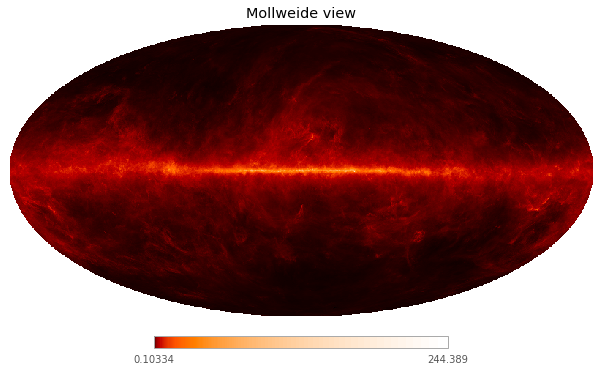

In [5]:
hp.mollview(ma, norm='log')

## Centers of patches

We specify the centers of the patches to be cut out. We apply a Galactic cut, and begin samples at `galactic_cut` + `step_size`. 
To cut out patches, we first define the set of points that will correspond to the centres of the patches we want. These centres will then be rotated to (0., 0.), and projected into a Cartesian grid. 

The first point is placed at (`galactic_cut` + `step_size`) in latitude, and 0 in longitude. From this we iterate over longitude in steps of `step_size` / $\cos(\theta)$.

In [6]:
southern_lat_range = list(np.arange(-90, -GAL_CUT, STEP_SIZE))
northern_lat_range = list(np.arange(GAL_CUT + STEP_SIZE, 90, STEP_SIZE))
lat_range = list(np.concatenate((southern_lat_range, northern_lat_range)))

In [7]:
centers = []
for t in lat_range:
    step = STEP_SIZE / np.cos(t * np.pi / 180.)
    for i in np.arange(0, 360, step):
        centers.append((i, t))
print("Number of patches: ", len(centers))

Number of patches:  1840


## Interpolating to flat sky maps

Given a set of points defining the centers of our patches, $l_c,~b_c$, we now cut out a square region of side $20^\circ$, centered on each of these patches. To do this consistently, and without incurring latitude-dependent artifacts, we first rotate the map to $(l,~b)=(0,~0)$, and then interpolate on a grid defined by $l \in [-10, 10], ~b\in[-10, 10]$

In [8]:
xlen = 10
ylen = 10
xres = 256
yres = 256

In [9]:
fc = began.FlatCutter(xlen, ylen, xres, yres)

### Checking the code

To ensure the rotation is doing what we expect, we define two new maps containing the latitude and longitude of each healpix pixel.

Text(0.5, 1.0, 'Latitude')

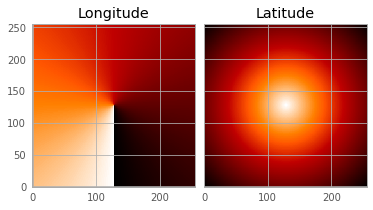

In [10]:
lon, lat = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)), lonlat=True)

test_point = [0, 90]

lon_proj = fc.rotate_and_interpolate(test_point, lon)
lat_proj = fc.rotate_and_interpolate(test_point, lat)

fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
plt.subplots_adjust(wspace=0.05)
ax[0].imshow(lon_proj, interpolation='nearest', origin='lower')
ax[0].set_title("Longitude")
ax[1].imshow(lat_proj, interpolation='nearest', origin='lower')
ax[1].set_title("Latitude")

# Cutting the real input map

We now iterate over the list of patch centers and compute the flat projection of each. 

In [11]:
cut_maps = [fc.rotate_and_interpolate(center, ma) for center in centers]

In [12]:
cut_maps = np.array(cut_maps)[..., None]

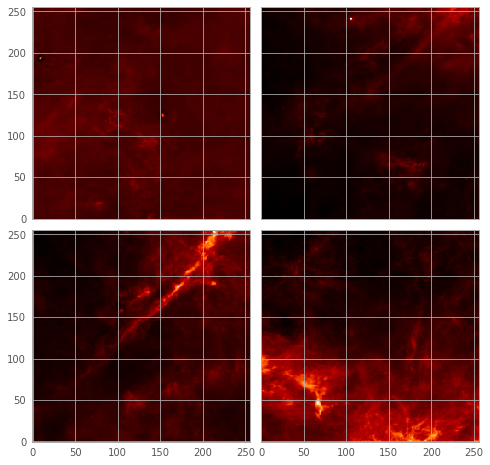

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.05, wspace=0.05)
ax[0, 0].imshow(cut_maps[0, :, :, 0], interpolation='nearest', origin='lower', aspect='auto')
ax[0, 1].imshow(cut_maps[100, :, :, 0], interpolation='nearest', origin='lower', aspect='auto')
ax[1, 0].imshow(cut_maps[321, :, :, 0], interpolation='nearest', origin='lower', aspect='auto')
ax[1, 1].imshow(cut_maps[1000, :, :, 0], interpolation='nearest', origin='lower', aspect='auto')

## Normalize the data in several ways to provide for training.

First we provide a set of images normalized by the global minimum and maximum.

In [14]:
cut_maps = np.log(cut_maps) 
log_cut_min = cut_maps.min()
log_cut_max = cut_maps.max()

In [15]:
cut_maps = 2 * (cut_maps - cut_maps.min()) / (cut_maps.max() - cut_maps.min()) - 1.

In [3]:
record_dir = Path("../data/preprocessed/")
fpath = record_dir / "GNILC_dust_map_{:d}_st{:d}_gcut{:d}.npy".format(RES, int(STEP_SIZE), int(GAL_CUT))

In [17]:
np.save(fpath, cut_maps)

In [17]:
def gen_to_real(log_min, log_max, ma):
    return np.exp((1. + ma) / 2 * (log_max - log_min) + log_min)

## Generator

    

In [18]:
import tensorflow as tf
gen = tf.keras.models.load_model("../models/generator.h5")

In [19]:
gen_arr = gen.predict(np.random.randn(1033, 64))

In [ ]:
gen_arr_exp = gen_to_real(log_cut_min, log_cut_max, gen_arr)

In [ ]:
print(norm_log_cut_maps.min())
print(norm_log_cut_maps.max())
print(gen_arr.min())
print(gen_arr.max())

In [ ]:
vmin = None
vmax = None
fig, ax = plt.subplots(3, 4, figsize=(16, 12), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.05, wspace=0.05)
for a in ax[0].ravel():
    a.imshow(cut_maps[np.random.randint(0, 1033), :, :, 0], interpolation='nearest', origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
for a in ax[1].ravel():
    a.imshow(gen_arr[np.random.randint(0, 1033), :, :, 0], interpolation='nearest', origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
for a in ax[2].ravel():
    a.imshow(kev_train_images[np.random.randint(0, 1033), :, :, 0], interpolation='nearest', origin='lower', aspect='auto', vmin=vmin, vmax=vmax)

## Power spectrum 

Also calculate the power spectrum of the maps for use in training. This is implemented with `NaMaster`1

In [8]:
import pymaster as nmt

cut_maps_arr = np.load(fpath)
xlen = 10
ylen = 10
xres = 256
yres = 256

In [9]:
Lx = 2 * xlen * np.pi/180
Ly = 2 * ylen * np.pi/180
Nx = xres
Ny = yres


In [10]:
mask = np.ones(Nx * Ny).reshape((Nx, Ny))
xarr = np.ones(Ny)[:, None] * np.arange(Nx)[None, :] * Lx/Nx
yarr = np.ones(Nx)[None, :] * np.arange(Ny)[:, None] * Ly/Ny

In [11]:
mask = nmt.mask_apodization_flat(mask, Lx, Ly, aposize=1., apotype="C1")

In [12]:
f0 = nmt.NmtFieldFlat(Lx, Ly, mask, [cut_maps_arr[100, :, :, 0]])
l0_bins = np.arange(Nx/8) * 8 * np.pi/Lx
b = nmt.NmtBinFlat(l0_bins, l0_bins)

In [13]:
w00 = nmt.NmtWorkspaceFlat()
w00.compute_coupling_matrix(f0, f0, b)

In [14]:
def get_uncoupled_spectrum(wsp, field0, nmtbin):
    cl_coupled = nmt.compute_coupled_cell_flat(field0, field0, nmtbin)
    return wsp.decouple_cell(cl_coupled)

cl = np.empty((cut_maps_arr.shape[0], b.get_n_bands()))
cl_gen = np.empty((cut_maps_arr.shape[0], b.get_n_bands()))
for i in range(cut_maps_arr.shape[0]):
    field = nmt.NmtFieldFlat(Lx, Ly, mask, [cut_maps_arr[i, :, :, 0]])
    cl[i] = get_uncoupled_spectrum(w00, field, b)
    #field_gen = nmt.NmtFieldFlat(Lx, Ly, mask, [gen_arr_exp[i, :, :, 0]])
    #cl_gen[i] = get_uncoupled_spectrum(w00, field_gen, b)

In [15]:
ells_uncoupled = b.get_effective_ells()

Text(0, 0.5, '$C_\\ell$')

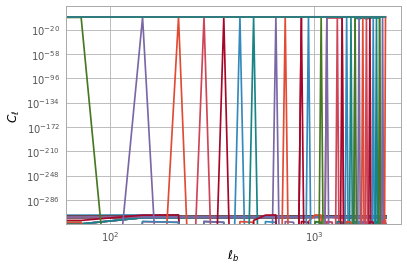

In [23]:
fig, ax = plt.subplots(1, 1)
for i in range(cut_maps_arr.shape[0]):
    ax.loglog(ells_uncoupled, cl_gen[i])
ax.set_xlabel(r"$\ell_b$")
ax.set_ylabel(r"$C_\ell$")

In [18]:
pcts = np.percentile(np.log10(cl), [5, 32, 50, 68, 95], axis=0) / np.mean(np.log10(cl), axis=0)
pcts_gen = np.percentile(np.log10(cl_gen), [5, 32, 50, 68, 95], axis=0) / np.mean(np.log10(cl_gen), axis=0)

/home/bthorne/projects/gan/began/envs-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


(0.85, 1.15)

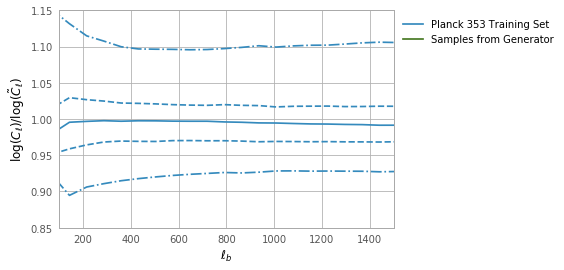

In [19]:
fig, ax = plt.subplots(1, 1)
ax.plot(ells_uncoupled, pcts[0], '-.C0')
ax.plot(ells_uncoupled, pcts[1], '--C0')
ax.plot(ells_uncoupled, pcts[2], 'C0', label='Planck 353 Training Set')
ax.plot(ells_uncoupled, pcts[3], '--C0')
ax.plot(ells_uncoupled, pcts[4], '-.C0')
ax.plot(ells_uncoupled, pcts_gen[0], '-.C3')
ax.plot(ells_uncoupled, pcts_gen[1], '--C3')
ax.plot(ells_uncoupled, pcts_gen[2], 'C3', label='Samples from Generator')
ax.plot(ells_uncoupled, pcts_gen[3], '--C3')
ax.plot(ells_uncoupled, pcts_gen[4], '-.C3')
ax.set_xlabel(r"$\ell_b$")
ax.set_ylabel(r"$\log(C_\ell) / \log(\tilde{C}_\ell)$")
ax.set_xlim(100, 1500)
ax.legend(bbox_to_anchor=(1. ,1.), loc='upper left', frameon=False)
ax.set_ylim(0.85, 1.15)

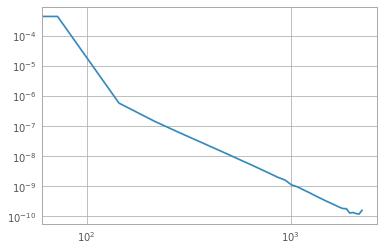

In [20]:
fig, ax = plt.subplots(1, 1)
ax.loglog(ells_uncoupled, np.mean(cl, axis=0))
ax.loglog(ells_uncoupled, np.mean(cl_gen, axis=0))

/home/bthorne/projects/gan/began/envs-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/bthorne/projects/gan/began/envs-gpu/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/bthorne/projects/gan/began/envs-gpu/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 0, '$\\log(C_{288}) / \\log(\\tilde{C}_{288})$')

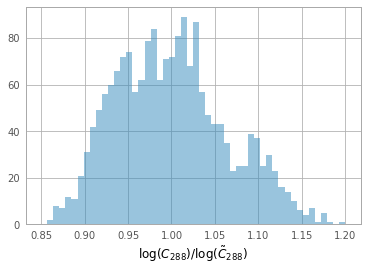

In [21]:
fig, ax = plt.subplots(1, 1)
ax.hist(np.log10(cl[:, 3]) / np.mean(np.log10(cl[:, 3])), bins=50, range=[0.85, 1.2], alpha=0.5)
ax.hist(np.log10(cl_gen[:, 3]) / np.mean(np.log10(cl_gen[:, 3])), bins=50, range=[0.85, 1.2], alpha=0.5)
ax.set_xlabel(r"$\log(C_{288}) / \log(\tilde{C}_{288})$")

## Save